In [2]:
# Import necessary libraries
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# %matplotlib notebook

## Gradient descent - Adam
Implementing the Adam optimiser and examining behaviour on the
function
$$(1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + x y^3)^2$$
We implement the Adam optimiser and visualise its behaviour for two different starting points and two different learning rates.  
For a learning rate of $10^{-3}$ ($\gamma= 0.9$, $\beta = 0.99$, $\epsilon = 10^{-8}$), we scan over a sensible grid of starting points. Highlighting the different endpoints associated to these starting points in a contour plot.

### Solution
Note that the function above is known as [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization).

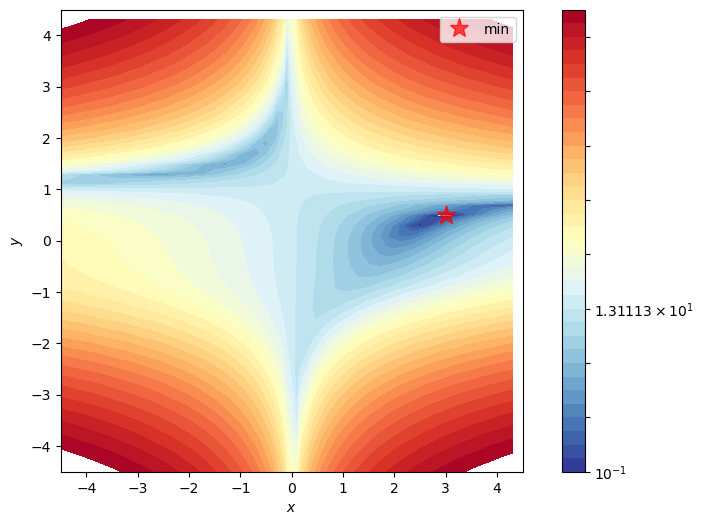

In [3]:
# Code used here is mostly from the "A high-bias, low-variance introduction to Machine Learning for physicists" review by Mehta et al.

# Define the function and its gradient 

def beales_function(x,y):
    return np.square(1.5-x+x*y) + np.square(2.25-x+x*y*y) + np.square(2.625-x+x*y**3)

def grad_beales_function(params):
    x = params[0]
    y = params[1]
    grad_x = 2*(1.5-x+x*y)*(-1+y) + 2*(2.25-x+x*y**2)*(-1+y**2) + 2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y = 2*(1.5-x+x*y)*x + 4*(2.25-x+x*y**2)*x*y + 6*(2.625-x+x*y**3)*x*y**2
    return [grad_x, grad_y]

# Define function that contour plots our function and its minimum

def contour_beales_function(color_bool = True):
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z = beales_function(x,y)
    if color_bool:
        cax = ax.contourf(x, y, z, levels = np.logspace(-1, 5, 35), norm = LogNorm(), cmap="RdYlBu_r")
    else:
        cax = ax.contourf(x, y, z, levels = np.logspace(-1, 5, 35), norm = LogNorm(), cmap = "Greys")
    ax.plot(3, 0.5, 'r*', markersize = 14, label = 'min', alpha = 0.7)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    ax.legend()
    color_bar = fig.colorbar(cax, ax=ax, orientation='vertical')
    ax.set_aspect('equal')
    return fig,ax

# Function to plot the trajectory taken by the gradient descent
def overlay_trajectory_contour(ax, trajectory, label, lw = 2):
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    line, = ax.plot(xs, ys, label = label, lw = lw, alpha = 0.5)
    line_color = line.get_color()
    ax.plot(xs[-1], ys[-1], '>', markersize = 8, color=line_color)
    ax.plot(xs[0], ys[0],'o', markersize = 8, color=line_color, alpha = 0.9)
    return ax

fig, ax = contour_beales_function()
plt.show()

So one needs to be careful about the local minima at the top left!

In [4]:
# Implement the ADAM optimizer
def adam(grad, init, n_epochs = 5000, eta = 10**-3, gamma = 0.9, beta = 0.99, epsilon = 10**-8, noise_strength = 0):
    """
    An implementation of the Adam optimiser, without batching.
    
    Parameters
    ----------
    grad : func
        Gradient func of the loss func of interest, must return a list similar to input, which typically looks like init's content.
    init : list
        Initial point for the optimiser. Must match the input of func.
    eta, gamma, beta, epsilon : floats
        fixed learning rate, beta_1, beta_2, epsilon of previous notations.
    noise_strength: float
        Adding stochasticity to the gradient's computation.

    Returns
    -------
    np.ndarray
        History of the optima's position.

    """
    params = np.array(init) # current (x_i)s
    # storage for trajectory towards optima = # (n_epochs+1) x (x_i)
    param_traj = np.zeros([n_epochs+1, 2]) 
    param_traj[0,] = init
    m = 0 # or m_t
    grad_sq = 0 # second momentum
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        g = np.array(grad(params)) + noise # add stochasticity FOR BOTH REALISM AND ESCAPING WELLS. mini-batching is a natural way to do implement it instead.
        m = gamma*m + (1-gamma)*g # first moment estimate update
        grad_sq = beta*grad_sq + (1-beta)*g*g # second moment estimate update
        m_hat = m / (1-gamma**(j+1))
        grad_sq_hat = grad_sq / (1-beta**(j+1))
        # params = params - eta*np.divide(m_hat, np.sqrt(grad_sq_hat+epsilon))
        params = params - eta*np.divide(m_hat, np.sqrt(grad_sq_hat)+epsilon)
        param_traj[j+1,] = params
    return param_traj

def run_and_plot_optims(npoints = 3, **kwargs):
    # Define our grid of starting points:
    x = np.linspace(-3, 3, npoints)
    y = np.linspace(-3, 3, npoints)
    grid = np.meshgrid(x, y)
    grid = np.array([grid[0].reshape(npoints**2), grid[1].reshape(npoints**2)]).T


    # Separate contour plot
    fig, ax2 = contour_beales_function(color_bool = False)

    for init in grid:
        adam_trajectory = adam(grad_beales_function, init, **kwargs)
        overlay_trajectory_contour(ax2, adam_trajectory, 'ADAMS')
    plt.show()

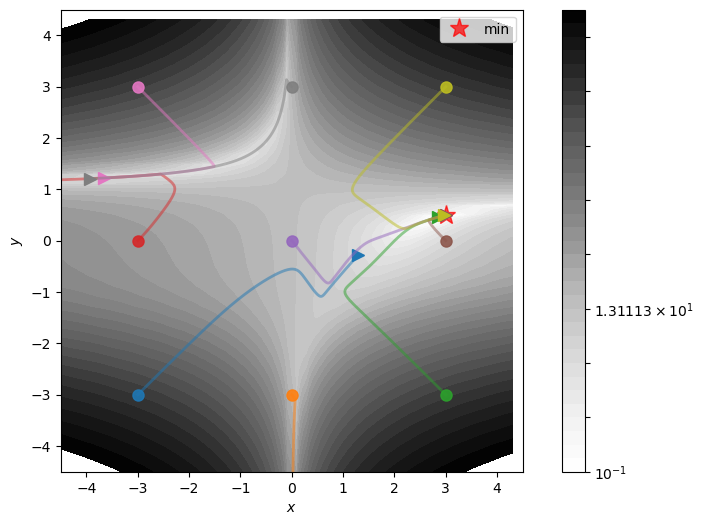

In [5]:
### default has no noise in gradient calculation
run_and_plot_optims()

Number of initial points can be crucial as an hyperparameter but might also be defeated in higher dimensions... hence stochasticity can help.

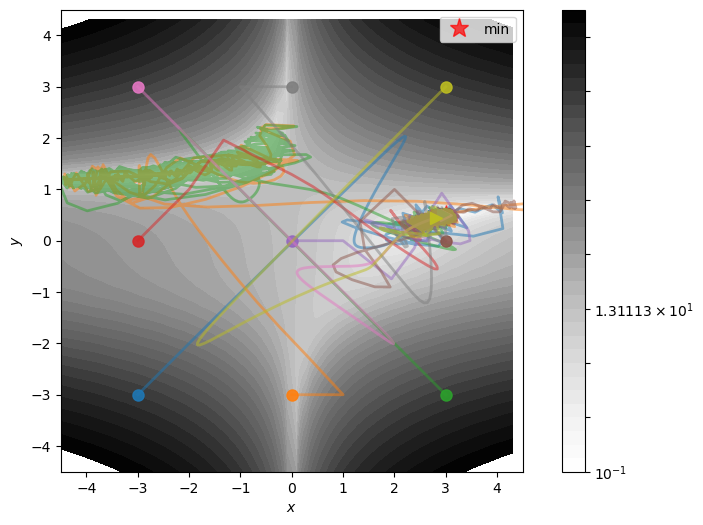

In [6]:
run_and_plot_optims(eta = 1, n_epochs = 10000)

we have escaped the local trap!

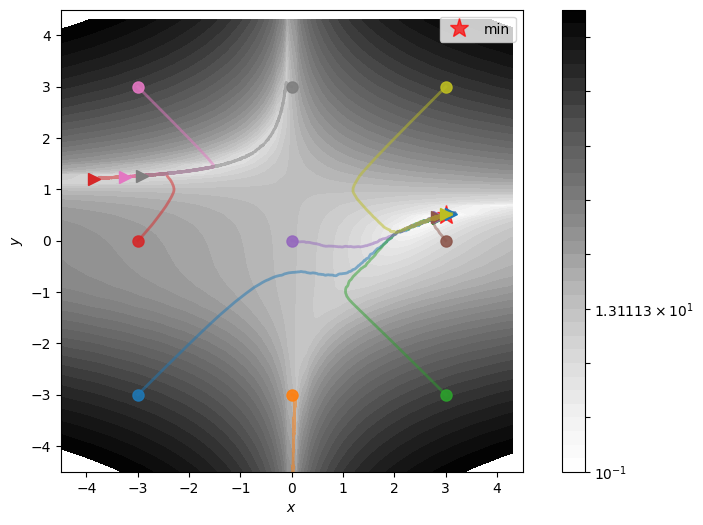

In [91]:
run_and_plot_optims(noise_strength = 5, n_epochs = 50000)

more noise in the gradient makes it longer to converge... because of second moment.